# Description

In [1]:
%pylab inline
from parcels import FieldSet, ParticleSet, JITParticle, Variable, AdvectionRK4, ErrorCode
import numpy as np
import xarray as xr
from datetime import timedelta, datetime, timezone
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
from netCDF4 import num2date, date2num

Populating the interactive namespace from numpy and matplotlib


In [2]:
from glob import glob
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from matplotlib import colors 

import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


# 2. Setting the velocity fields in a FieldSet object

In [3]:
nyears = [2018]

In [4]:
data_path = '/data/oceanparcels/input_data/ESA_WorldOceanCirculation/TropicalAtlantic/' 

fname = 'runWOC_TATL_v1_' + str(nyears[0]) + '*.nc' #'GlobCurrent_example_data/*0[7-8].nc'


In [5]:
ds_vel = xr.open_mfdataset(data_path + fname)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/site-packages/xarray/backends/api.py:931: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


# Setting mesh:

In [6]:
step = .5 # degrees
lons, lats = np.meshgrid(np.arange(-59, -49+step, step), np.arange(10, 20+step, step))
lons.shape[0]*lons.shape[1]

441

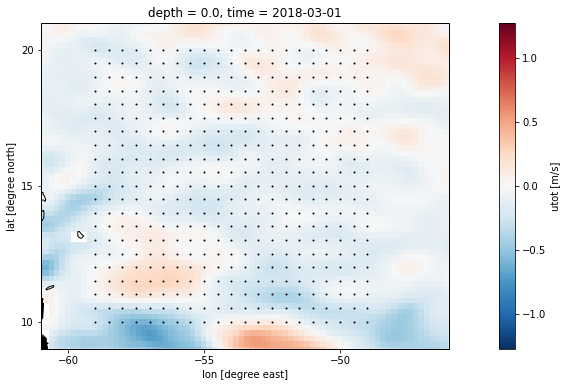

In [7]:
plt.figure(figsize=(18,6)) #(17,5)

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())


###################
# Non-tidal:
ax1.coastlines(resolution='50m')
ax1.add_feature(cartopy.feature.LAND, facecolor='black')

ax1.set_xlim([-61, -46])
ax1.set_ylim([9, 21])

ds_vel.utot[0,0,:,:].plot() # 0m

###-First point###
ax1.scatter(lons, lats, s=1, c='k', transform=ccrs.PlateCarree()) #marker='o'
###-Lines-###
#ax1.plot(ds_nT['lon'].T, ds_nT['lat'].T, transform=ccrs.PlateCarree())

#ax1.set_title('Points')

ax1.set_xticks([-60, -55., -50.], crs=ccrs.PlateCarree())
ax1.set_yticks([10., 15., 20.], crs=ccrs.PlateCarree())
# lon_formatter = LongitudeFormatter(number_format='.1f',degree_symbol='')
# lat_formatter = LatitudeFormatter(number_format='.1f',degree_symbol='')
# ax1.xaxis.set_major_formatter(lon_formatter)
# ax1.yaxis.set_major_formatter(lat_formatter)

#ax1.gridlines()
#ax1.legend()

plt.show()




# --> away from islands, just to avoid land point!

# fieldset:

In [7]:
filenames = {'U': data_path+fname, 'V': data_path+fname}
variables = {'U': 'utot', 'V': 'vtot'}
dimensions = {'lon': 'lon', 'lat': 'lat', 'time': 'time', 'depth': 'depth'} # comment depth in or out? for v0 not necessary!
indices = {'depth': [0]} # 0m
fieldset = FieldSet.from_netcdf(filenames, variables, dimensions, indices)

# 2. Defining the particles type and initial conditions in a ParticleSet object

In [8]:
# Convert datetime to second since fieldset time origin (time first UV file):
date_ini_fieldset = datetime.strptime(str(fieldset.time_origin)[0:-3], '%Y-%m-%dT%H:%M:%S.%f')

## 2.2 Setting the depth at which the horizontal 2D drift will take place:

In [9]:
depths = lons.copy()
depths[:] = 0.

# 2.3 Defining the kernels and particle class:

In [10]:
def add_WOC_nc_attbts(noutput_file, start_time, end_time, lomin, lomax, lamin, lamax
                      , input_filename, ntitle, summary, inid, ndepth):
    """
    Function to add the netCDF attributes.
    Inputs:
    start_time : "2017-01-01T00:28:08Z"
    
    (TATL)-99.0, -46.0, 5., 30.
    (NATL)-75.0, 20., 48., 80.
    
    ntitle: title
        * "North Atlantic 2D horizontal drift of Oil for ESA WOC project" 
        * "Tropical Atlantic 2D horizontal drift of Sargassum for ESA WOC project"  
    
    summary :"This dataset contains the positions of virtual particles at 
        * 0m
        * 15m 
    representing the trajectories of 
        * oil in the North Atlantic 
        * Sargassum in “the Tropical Atlantic"
    
    input_filename: input = "name of input filename(s). Ex : ERA5 (ocean currents) : file1
    ,  CMEMS (MULTIOBS_GLO_PHY_REP_015_004) : file2
        * NATL: "WOC-L4-CUReul-NATL-1H: runWOC_NATL_4lb_v1_201109*.nc"
        * TATL: "WOC-L4-CUReul-TATL-1H: runWOC_TATL_4lb_v1_201803*.nc"
        
    inid:
        * "WOC-L4-CURlag-NATL_OIL_SPILL_DRIFT_1H_INST" --> "NATL_OIL_SPILL_DRIFT_1H_INST"
        * "WOC-L4-CURlag-NATL_OIL_SPILL_DRIFT_1H_CONT" --> "NATL_OIL_SPILL_DRIFT_1H_CONT"
    ndepth
        * "0" or "15"

    """

    noutput_file.add_metadata('Conventions',"CF-1.7, ACDD-1.3, ISO 8601")
    noutput_file.add_metadata('Metadata_Conventions', "Climate and Forecast (CF) 1.7, Attribute Convention for Data Discovery (ACDD) 1.3")
    noutput_file.add_metadata('standard_name_vocabulary', "NetCDF Climate and Forecast (CF) Metadata Convention version 1.8")
            
    noutput_file.add_metadata('title', ntitle)
    noutput_file.add_metadata('summary', summary)
    
    noutput_file.add_metadata('id',  "WOC-L4-CURlag-" + inid) 
    noutput_file.add_metadata('institution', "Utrecht University, Institut Francais de Recherche pour l\'Exploitation de la mer / CERSAT, European Space Agency")
    noutput_file.add_metadata('institution_abbreviation', "Utrecht University, Ifremer/Cersat, ESA")
    noutput_file.add_metadata('references', "Delandmeter, P., & Sebille, E. V. The Parcels v2. 0 Lagrangian framework: new field interpolation schemes. Geoscientific Model Development 2019, vol. 12, No. 8, 3571-3584. https://doi.org/10.5194/gmd-12-3571-2019.")
    
    noutput_file.add_metadata('product_version',"1.0")
    noutput_file.add_metadata('keywords', "Earth Science > Oceans > Ocean Circulation > Ocean Currents")
    noutput_file.add_metadata('keywords_vocabulary', "NASA Global Change Master Directory (GCMD) Science Keywords")
        
    noutput_file.add_metadata('naming_authority', "fr.ifremer.cersat")
    noutput_file.add_metadata('cdm_data_type', "trajectory")
            
    noutput_file.add_metadata('comment',"These data were produced at IMAU, Utrecht University (Netherlands) as part of the ESA WOC project.")
    noutput_file.add_metadata('creator', 'Laura Gomez Navarro')
    noutput_file.add_metadata('creator_url', 'https://oceanparcels.org/')

    noutput_file.add_metadata('creator_email', "l.gomeznavarro@uu.nl")
    noutput_file.add_metadata('creator_institution',"IMAU, Utrecht University")

    noutput_file.add_metadata('project',"World Ocean Circulation (WOC) - European Space Agency")
    noutput_file.add_metadata('time_coverage_start', start_time)

    noutput_file.add_metadata('time_coverage_end', end_time)

    noutput_file.add_metadata('geospatial_lat_min', lamin)
    noutput_file.add_metadata('geospatial_lat_max', lamax)
    noutput_file.add_metadata('geospatial_lat_units',"degree_north")
    noutput_file.add_metadata('geospatial_lon_min', lomin)
    noutput_file.add_metadata('geospatial_lon_max', lomax)
    noutput_file.add_metadata('geospatial_lon_units', "degree_east")
    noutput_file.add_metadata('geospatial_vertical_min', ndepth)
    noutput_file.add_metadata('geospatial_vertical_max', ndepth)
    noutput_file.add_metadata('geospatial_vertical_units', "meters below mean sea level")
    noutput_file.add_metadata('geospatial_vertical_positive', "down")
                              
    noutput_file.add_metadata('license', "ESA WOC Data Policy: free and open access")

    noutput_file.add_metadata('netcdf_version_id', "4.6.1 of May 13 2018 11:35:43 $")
    noutput_file.add_metadata('acknowledgement', "Please acknowledge the use of these data with the following statement: these data were obtained from the ESA WOC project")
    noutput_file.add_metadata('format_version', "WOC v1.0")
    noutput_file.add_metadata('processing_level', "L4")
    noutput_file.add_metadata('method'
            ,"2D lagrangian advection using Runge-Kutta4 and executed using the OceanParcels framework")
    
    import uuid
    noutput_file.add_metadata('track_id', str(uuid.uuid4()))

    noutput_file.add_metadata('publisher_name',"CERSAT")
    noutput_file.add_metadata('publisher_url',"cersat.ifremer.fr")
    noutput_file.add_metadata('publisher_email',"cersat@ifremer.fr")
    noutput_file.add_metadata('publisher_institution',"Ifremer / CERSAT")
    noutput_file.add_metadata('scientific_support_contact', "l.gomeznavarro@uu.nl")

    noutput_file.add_metadata('technical_support_contact',"cersat@ifremer.fr")
    noutput_file.add_metadata('key_variables',"eastward_eulerian_current_velocity, westward_eulerian_current_velocity")
    noutput_file.add_metadata('date_created',"2021-06-01 10:43:21") # modify for TATL and other simus NATL
    noutput_file.add_metadata('date_modified', "2021-06-01 10:43:21") # modify for TATL and other simus NATL
    noutput_file.add_metadata('source',"parcels")
    noutput_file.add_metadata('source_version',"2.2.2.dev126+g6dd05b7")
    noutput_file.add_metadata('history',"2021-06-01 10:43:21 - Creation") # modify for TATL and other simus NATL
    noutput_file.add_metadata('input', input_filename)

    noutput_file.add_metadata('processing_software',"parcels")


In [11]:
def DeleteParticle(particle, fieldset, time):
    particle.delete()

def AgeParticle(particle, fieldset, time):
    if particle.state == ErrorCode.Evaluate:
        particle.age += math.fabs(particle.dt)
    if particle.age > fieldset.maxage:
        particle.delete()

class DrifterParticle(JITParticle):
    age = Variable('age')


# 2.4 ParticleSet:

In [12]:
pset = ParticleSet(fieldset, pclass=DrifterParticle, lon=lons,
                           lat=lats, time=datetime(nyears[0], 3, 1, 0, 0), depth=depths) #, 30)
        

# 3. Executing the simulation:

# 3.1. Defining parameters

In [13]:
fieldset.maxage = timedelta(days=90.).total_seconds() 
runtime = fieldset.maxage

outdir =  "/data/oceanparcels/output_data/data_LauraGN/outputs_parcels/WOC/Sargassum/"
pfname = '20180301000000-WOC-L4-CURlag-TATL_sargassum_drift_1H_00m_mesh_90days-v1.0-fv1.0.nc'

output_file = pset.ParticleFile(name=outdir + pfname, outputdt=timedelta(hours=1))


# 3.2 Running

In [14]:
pset.execute(pset.Kernel(AdvectionRK4)+AgeParticle, runtime=runtime, dt=timedelta(minutes=10),
             recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle}, output_file=output_file)

timep = datetime(2018,3,1)
start_time = timep.isoformat()
time_unit_out= "seconds since " + str(pset.time_origin)
#end_time = (num2date(output_file.time[:].max(), time_unit_out)).isoformat()
end_time = (num2date(max(output_file.time_written), time_unit_out)).isoformat()

add_WOC_nc_attbts(output_file, start_time, end_time, -99.0, -46.0, 5., 30.
        , input_filename="WOC-L4-CUReul-TATL-1H: runWOC_TATL_4lb_v1_2018*.nc"
        , ntitle="Tropical Atlantic 2D horizontal drift of Sargassum for ESA WOC project" 
        , summary="This dataset contains the positions of virtual particles released on a regular grid (mesh) on 01/03/2018 at 0m representing the trajectories of Sargassum in the Tropical Atlantic."
        , inid = "TATL_SARGASSUM_DRIFT_1H_MESH"
        , ndepth = "0")

output_file.export()  # exports the trajectory data to a netcdf file


INFO: Compiled DrifterParticleAdvectionRK4AgeParticle ==> /tmp/parcels-319202/706a316fe4c0a27ea2cc1682e6c1edd1_0.so
INFO: Temporary output files are stored in /data/oceanparcels/output_data/data_LauraGN/outputs_parcels/WOC/Sargassum/out-PPERGPVS.
INFO: You can use "parcels_convert_npydir_to_netcdf /data/oceanparcels/output_data/data_LauraGN/outputs_parcels/WOC/Sargassum/out-PPERGPVS" to convert these to a NetCDF file during the run.
100% |########################################################################|


In [15]:
!ls /data/oceanparcels/output_data/data_LauraGN/outputs_parcels/WOC/Sargassum/

20180301000000-WOC-L4-CURlag-TATL_sargassum_drift_1H_00m_mesh_90days-v1.0-fv1.0.nc
20180301000000-WOC-L4-CURlag-TATL_sargassum_drift_1H_15m_mesh_90days-v1.0-fv1.0.nc
20180301000000-WOC-L4-CURlag_15m-TATL_SARGASSUM_DRIFT_1H_MESH-v1.0-fv2.0.nc
20180312065959-WOC-L4-CURlag-TATL_sargassum_drift_1H_00m_drifters_10days-v1.0-fv1.0.nc
20180312065959-WOC-L4-CURlag-TATL_sargassum_drift_1H_00m_drifters_180days-v1.0-fv1.0.nc
20180312065959-WOC-L4-CURlag-TATL_sargassum_drift_1H_15m_V3_drifters_180days-v1.0-fv1.0.nc
20180312065959-WOC-L4-CURlag-TATL_sargassum_drift_1H_15m_drifters_180days-v1.0-fv1.0.nc
20180312065959-WOC-L4-CURlag-TATL_sargassum_drift_1H_15m_drifters_20days-v1.0-fv1.0.nc
20180312070000-WOC-L4-CURlag_00m-TATL_SARGASSUM_DRIFT_1H_DRIFTERS-v1.0-fv2.0.nc
20180312070000-WOC-L4-CURlag_15m-TATL_SARGASSUM_DRIFT_1H_DRIFTERS-v1.0-fv2.0.nc
CMEMS-TATL_sargassum_drift_1H_00m_10days_d2.nc
CMEMS-TATL_sargassum_drift_1H_00m_drifters_180days-v1.0-fv1.0.nc
CMEMS-TATL_sargassum_drift_1H_15m_drifters_18

In [16]:
!rm -rf /data/oceanparcels/output_data/data_LauraGN/outputs_parcels/WOC/Sargassum/out-*

# 4. Checking the outputs:

In [17]:
!ncdump -h  /data/oceanparcels/output_data/data_LauraGN/outputs_parcels/WOC/Sargassum/20180301000000-WOC-L4-CURlag-TATL_sargassum_drift_1H_00m_mesh_90days-v1.0-fv1.0.nc


netcdf \20180301000000-WOC-L4-CURlag-TATL_sargassum_drift_1H_00m_mesh_90days-v1.0-fv1.0 {
dimensions:
	obs = 2161 ;
	traj = 441 ;
variables:
	int64 trajectory(traj, obs) ;
		trajectory:_FillValue = -9223372036854775808L ;
		trajectory:long_name = "Unique identifier for each particle" ;
		trajectory:cf_role = "trajectory_id" ;
	double time(traj, obs) ;
		time:_FillValue = NaN ;
		time:long_name = "" ;
		time:standard_name = "time" ;
		time:units = "seconds since 2018-03-01T00:00:00.000000000" ;
		time:calendar = "standard" ;
		time:axis = "T" ;
	float lat(traj, obs) ;
		lat:_FillValue = NaNf ;
		lat:long_name = "" ;
		lat:standard_name = "latitude" ;
		lat:units = "degrees_north" ;
		lat:axis = "Y" ;
	float lon(traj, obs) ;
		lon:_FillValue = NaNf ;
		lon:long_name = "" ;
		lon:standard_name = "longitude" ;
		lon:units = "degrees_east" ;
		lon:axis = "X" ;
	float z(traj, obs) ;
		z:_FillValue = NaNf ;
		z:long_name = "" ;
		z:standard_name = "depth" ;
		z:units = "m" ;
		z:positive = "d

# Plotting first output:

In [18]:
ds = xr.open_dataset(outdir + pfname)


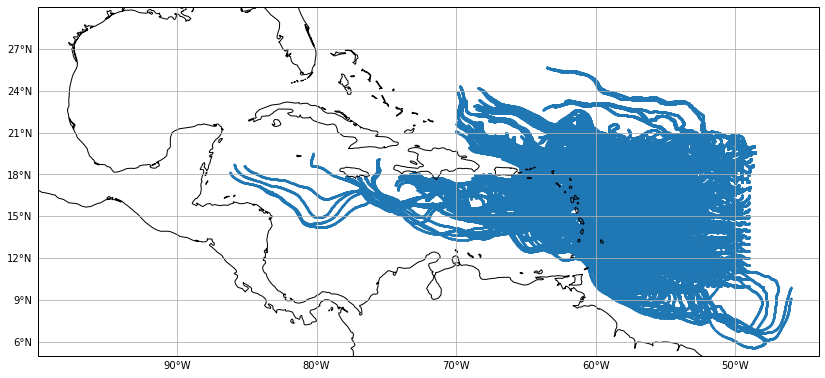

In [19]:
plt.figure(figsize=(14,14)) #(17,5)

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
ax1.coastlines(resolution='50m')
#ax1.add_feature(cartopy.feature.LAND, facecolor='black')
ax1.scatter(ds['lon'], ds['lat'], s=1, transform=ccrs.PlateCarree()) #marker='o'
ax1.set_xlim([-100., -44.])
ax1.set_ylim([5., 30.])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False
#gl.ylocator = mticker.FixedLocator([0, 5, 10, 15, 20, 25, 30, 35])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER